## Mapping of healthy lung dataset Meyer_2021 to the HLCA core + downstream analysis:

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib_venn import venn3
import os

for nice code formatting:

In [2]:
%load_ext lab_black

initiate empty dictionary to store figures:

In [3]:
FIGURES = dict()

fig params:

In [4]:
plt.rcParams["figure.figsize"] = (7, 7)

set paths:

In [5]:
path_core_plus_meyer = "../../data/HLCA_extended/HLCA_core_plus_single_study/HLCA_meyer_2021_adata_full_tcnorm_log1p.h5ad"
dir_figures = "../../results/figures/"

load data:

In [6]:
adata = sc.read(path_core_plus_meyer)

plot clusters and annotations to see which cluster has the fibroblasts:

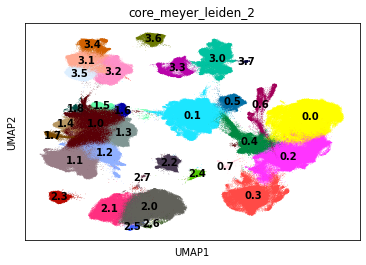

In [7]:
sc.pl.umap(adata, color="core_meyer_leiden_2", legend_loc="on data", s=1)

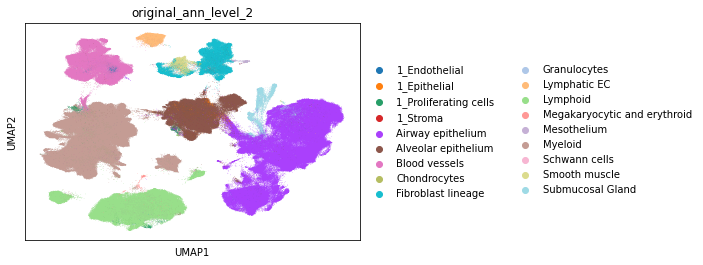

In [8]:
sc.pl.umap(adata, color="original_ann_level_2", s=1)

store number of cells per meyer annotatin:

In [9]:
ct_counts_meyer = adata.obs.loc[
    adata.obs.study == "Meyer_2021", "original_celltype_ann"
].value_counts()
ct_counts_meyer = ct_counts_meyer[ct_counts_meyer > 0]

subset to fibroblast clusters (cluster 3.1, 3.3, also contain smooth muscle):

In [10]:
cloi = ["3.0", "3.3"]
cl_fibs_sm = adata[adata.obs.core_meyer_leiden_2.isin(cloi), :].copy()

store number of cells per meyer annotation in cl_fibs_sm:

In [11]:
ct_counts_fibs_sm = cl_fibs_sm.obs.loc[
    cl_fibs_sm.obs.study == "Meyer_2021", "original_celltype_ann"
].value_counts()
ct_counts_fibs_sm = ct_counts_fibs_sm[ct_counts_fibs_sm > 0]

store cell types that we are interested in (i.e. unknown cell types with spatial annotation (or that were found because of spatial analysis) beyond parenchyma/airway), of which more than 5 cells are present. 

In [12]:
sorted(ct_counts_fibs_sm.index)

['AT1',
 'Basal',
 'Chondrocyte',
 'DC_activated',
 'DC_plasmacytoid',
 'Endothelia_vascular_Cap_g',
 'Endothelia_vascular_venous_systemic',
 'Erythrocyte',
 'Fibro_adventitial',
 'Fibro_alveolar',
 'Fibro_immune_recruiting',
 'Fibro_myofibroblast',
 'Fibro_peribronchial',
 'Macro_CHIT1',
 'Macro_alveolar',
 'Megakaryocyte',
 'Mesothelia',
 'Monocyte_CD14',
 'Muscle_pericyte_pulmonary',
 'Muscle_pericyte_systemic',
 'Muscle_perivascular_venous_immune_recruiting',
 'Muscle_smooth_airway',
 'Muscle_smooth_arterial_systemic',
 'Muscle_smooth_pulmonary',
 'NAF_endoneurial',
 'NAF_perineurial',
 'SMG_Basal',
 'Schwann_Myelinating',
 'Schwann_nonmyelinating']

In [13]:
cts_of_interest = [
    "Fibro_immune_recruiting",
    "Chondrocyte",
    "NAF_endoneurial",
    "NAF_perineurial",
    "Schwann_Myelinating",
    "Schwann_nonmyelinating",
]

generate simplified columns with original_annotations only from meyer data, and setting cell types with fewer than min_n_cells to "other"

In [14]:
min_n_cells = 5
cl_fibs_sm.obs["original_celltype_ann_meyer"] = None
cl_fibs_sm.obs.loc[
    cl_fibs_sm.obs.study == "Meyer_2021", "original_celltype_ann_meyer"
] = cl_fibs_sm.obs.loc[cl_fibs_sm.obs.study == "Meyer_2021", "original_celltype_ann"]
orig_ann_meyer_mapper = {ct: ct for ct in cl_fibs_sm.obs.original_celltype_ann_meyer}
for ct in ct_counts_fibs_sm.index:
    if ct_counts_fibs_sm[ct] < min_n_cells:
        orig_ann_meyer_mapper[ct] = "other"
cl_fibs_sm.obs[
    "original_celltype_ann_meyer"
] = cl_fibs_sm.obs.original_celltype_ann_meyer.map(orig_ann_meyer_mapper)

same for original_ann_level_4_clean

In [15]:
annlev4cl_mapper = {ct: ct for ct in cl_fibs_sm.obs.original_ann_level_4}
ct_counts = cl_fibs_sm.obs.original_ann_level_4.value_counts()
for ct in ct_counts.index:
    if ct_counts[ct] < 10:
        annlev4cl_mapper[ct] = "other"
cl_fibs_sm.obs[
    "original_ann_level_4_clean_filt"
] = cl_fibs_sm.obs.original_ann_level_4.map(annlev4cl_mapper)

re-calculate neighbor graph and umap:

neighbor graph with low k, to enable finding small clusters:

In [16]:
sc.pp.neighbors(cl_fibs_sm, use_rep="X_scanvi_emb", n_neighbors=10)

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
sc.tl.umap(cl_fibs_sm)

In [18]:
cl_fibs_sm.shape

(39374, 29544)

plot umap:

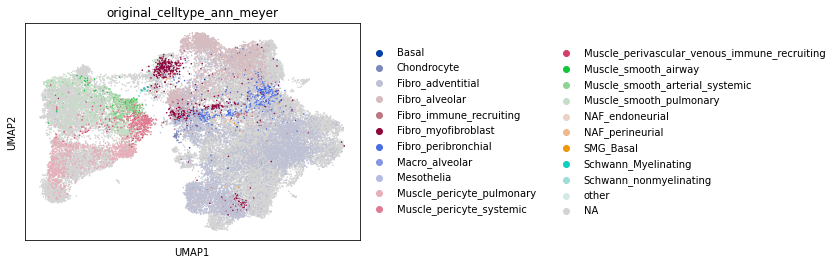

In [19]:
sc.pl.umap(cl_fibs_sm, color="original_celltype_ann_meyer", s=10)

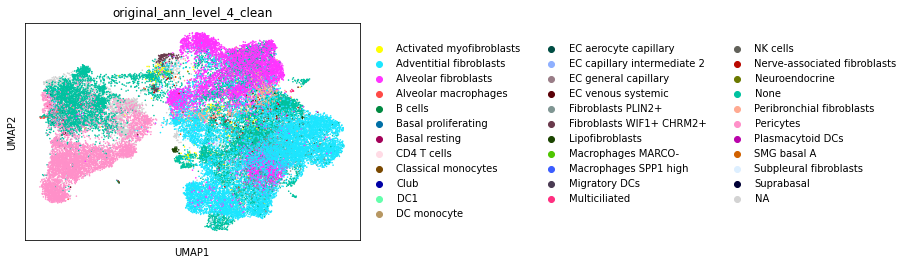

In [20]:
sc.pl.umap(cl_fibs_sm, color="original_ann_level_4_clean", s=10)

### Identification of clusters that (best) capture spatially annotated fibroblast subtypes:

Loop through low to high clustering resolutions. For every resolution, check if any clusters fulfill the "spatial_cluster" criteria for any of the spatial cell types, i.e. if there are any clusters with a min_sensitivity recall (among Meyer_2021 cells only) and a min_specificity precision (among Meyer_2021 cells only).  
Then check at which resolution the summed sensitivity of spatial_clusters was highest for a specific cell type, that is the best resolution for that cell type. Store matching clusters, recall and precision.

RES 0.1:
n clusters: 3


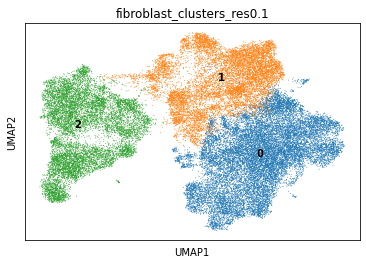




RES 0.2:
n clusters: 6


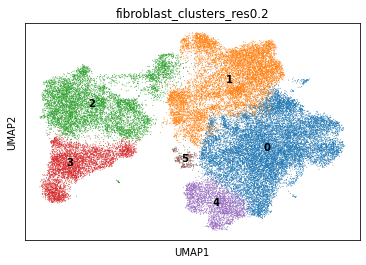




RES 0.5:
n clusters: 13


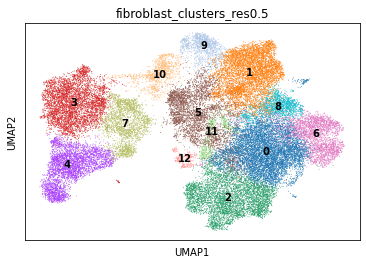




RES 1:
n clusters: 20


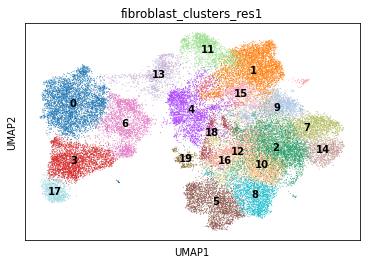




RES 2:
n clusters: 36


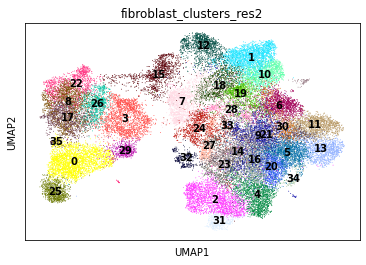




RES 3:
n clusters: 48


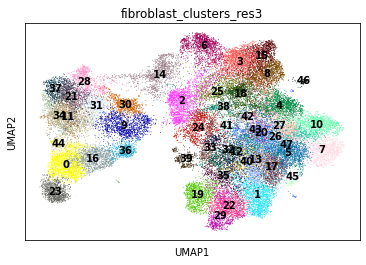




RES 5:
n clusters: 74


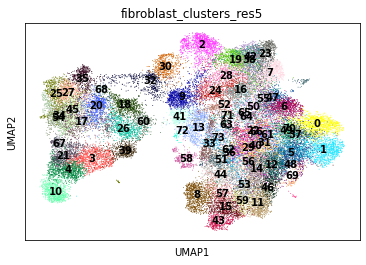

Chondrocyte best so far
Chondrocyte
cluster 72, specificity/precision: 55.36
cluster 72, sensitivity/recall: 73.81
NAF_perineurial best so far
NAF_perineurial
cluster 72, specificity/precision: 28.57
cluster 72, sensitivity/recall: 51.61



RES 10:
n clusters: 132


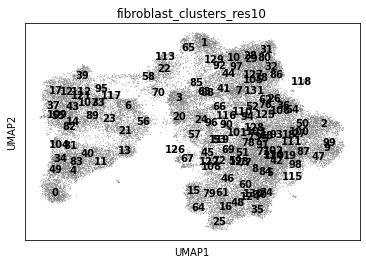

Chondrocyte best so far
Chondrocyte
cluster 70, specificity/precision: 33.33
cluster 70, sensitivity/recall: 83.33



RES 15:
n clusters: 190


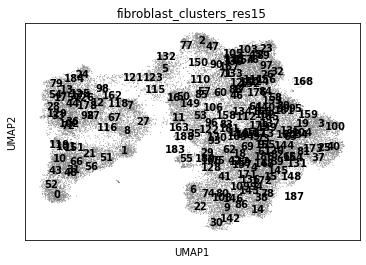

Chondrocyte best so far
Chondrocyte
cluster 163, specificity/precision: 60.66
cluster 163, sensitivity/recall: 88.1



RES 20:
n clusters: 237


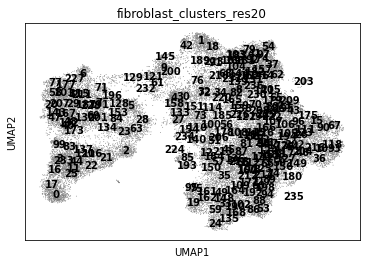

Chondrocyte
cluster 158, specificity/precision: 57.38
cluster 158, sensitivity/recall: 83.33
Fibro_immune_recruiting best so far
Fibro_immune_recruiting
cluster 226, specificity/precision: 70.0
cluster 226, sensitivity/recall: 35.59
Schwann_Myelinating best so far
Schwann_Myelinating
cluster 232, specificity/precision: 41.18
cluster 232, sensitivity/recall: 100.0



RES 25:
n clusters: 343


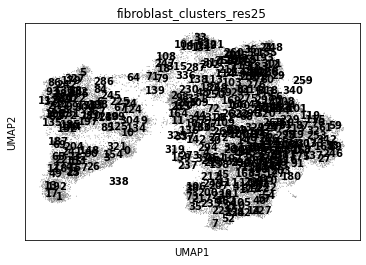

Accepting a slight drop in sensitivity for a high gain in specificity for Chondrocyte
Chondrocyte best so far
Chondrocyte
cluster 325, specificity/precision: 93.94
cluster 325, sensitivity/recall: 73.81
Fibro_immune_recruiting
cluster 332, specificity/precision: 74.07
cluster 332, sensitivity/recall: 33.9
NAF_perineurial best so far
NAF_perineurial
cluster 316, specificity/precision: 69.57
cluster 316, sensitivity/recall: 51.61
Schwann_Myelinating
cluster 287, specificity/precision: 41.18
cluster 287, sensitivity/recall: 100.0



RES 30:
n clusters: 418


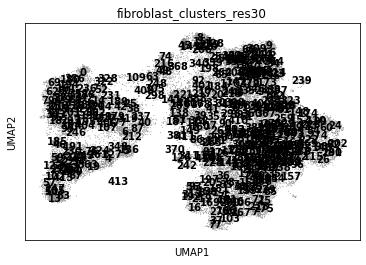

Chondrocyte best so far
Chondrocyte
cluster 381, specificity/precision: 91.43
cluster 381, sensitivity/recall: 76.19
Fibro_immune_recruiting
cluster 393, specificity/precision: 74.07
cluster 393, sensitivity/recall: 33.9
NAF_perineurial
cluster 353, specificity/precision: 55.17
cluster 353, sensitivity/recall: 51.61
Schwann_Myelinating
cluster 409, specificity/precision: 41.18
cluster 409, sensitivity/recall: 100.0



RES 50:
n clusters: 684


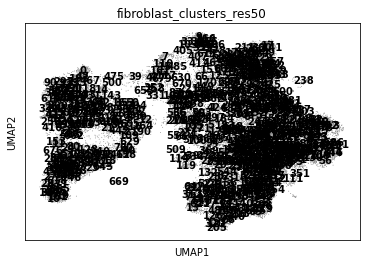

Chondrocyte
cluster 553, specificity/precision: 93.94
cluster 553, sensitivity/recall: 73.81
Fibro_immune_recruiting best so far
Fibro_immune_recruiting
cluster 364, specificity/precision: 46.81
cluster 364, sensitivity/recall: 37.29
NAF_perineurial
cluster 497, specificity/precision: 69.57
cluster 497, sensitivity/recall: 51.61
Schwann_Myelinating
cluster 653, specificity/precision: 41.18
cluster 653, sensitivity/recall: 100.0



RES 80:


/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/scanpy/tools/_leiden.py:160: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  categories=natsorted(map(str, np.unique(groups))),


n clusters: 1098


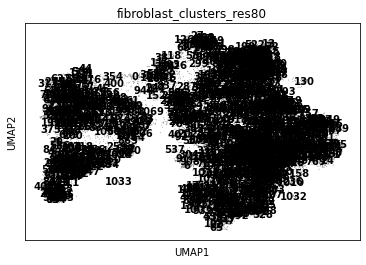

Chondrocyte best so far
Chondrocyte
cluster 401, specificity/precision: 90.0
cluster 401, sensitivity/recall: 85.71
Fibro_immune_recruiting best so far
Fibro_immune_recruiting
cluster 561, specificity/precision: 74.19
cluster 561, sensitivity/recall: 38.98
NAF_perineurial best so far
NAF_perineurial
cluster 827, specificity/precision: 72.73
cluster 827, sensitivity/recall: 51.61
Schwann_Myelinating
cluster 944, specificity/precision: 41.18
cluster 944, sensitivity/recall: 100.0



RES 100:
n clusters: 1327


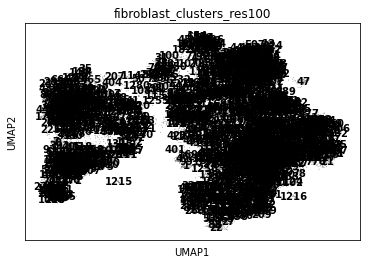

Chondrocyte
cluster 422, specificity/precision: 94.12
cluster 422, sensitivity/recall: 76.19
Fibro_immune_recruiting
cluster 553, specificity/precision: 75.86
cluster 553, sensitivity/recall: 37.29
NAF_perineurial best so far
NAF_perineurial
cluster 973, specificity/precision: 84.21
cluster 973, sensitivity/recall: 51.61
Schwann_Myelinating
cluster 1081, specificity/precision: 41.18
cluster 1081, sensitivity/recall: 100.0





In [21]:
min_sensitivity = 25
min_specificity = 25
ct_clusters_per_res = dict()
ct_perc_per_cl_per_res = dict()
ct_perc_over_cls_per_res = dict()
ct_best_performing_res = {ct: (0, 0, 0) for ct in cts_of_interest}
n_neighbors = 0
for res in [0.1, 0.2, 0.5, 1, 2, 3, 5, 10, 15, 20, 25, 30, 50, 80, 100]:
    print(f"RES {res}:")
    # calculate neighbor graph:
    if res < 25:
        new_n_neighbors = 30
    if res >= 25:
        new_n_neighbors = 15
    if new_n_neighbors != n_neighbors:
        n_neighbors = new_n_neighbors
        sc.pp.neighbors(cl_fibs_sm, n_neighbors=n_neighbors, use_rep="X_scanvi_emb")
    # cluster
    sc.tl.leiden(
        cl_fibs_sm,
        key_added=f"fibroblast_clusters_res{res}",
        resolution=res,
        random_state=0,
    )
    print("n clusters:", len(cl_fibs_sm.obs[f"fibroblast_clusters_res{res}"].unique()))
    sc.pl.umap(cl_fibs_sm, color=f"fibroblast_clusters_res{res}", legend_loc="on data")
    # store number of ct per cl
    meyerct_per_cl = pd.crosstab(
        cl_fibs_sm.obs[f"fibroblast_clusters_res{res}"],
        cl_fibs_sm.obs.original_celltype_ann_meyer,
    )
    # remove nans (non-meyer cells)
    meyerct_per_cl = meyerct_per_cl.loc[
        :, [col for col in meyerct_per_cl.columns if col != "nan"]
    ]
    # convert to percentages per cl (meyer cells only), i.e. precision
    ct_perc_per_cl = round(
        meyerct_per_cl.divide(meyerct_per_cl.sum(axis=1), axis="rows") * 100, 2
    )
    ct_perc_per_cl_per_res[res] = ct_perc_per_cl
    # ct percentages over clusters, i.e. recall
    ct_perc_over_cls = round(
        meyerct_per_cl.divide(meyerct_per_cl.sum(axis=0), axis="columns") * 100, 2
    )
    # store in dictionary, to check later on if wanted
    ct_perc_over_cls_per_res[res] = ct_perc_over_cls
    # initiate dictionary to store clusters of relevance for this resolution
    ct_clusters_per_res[res] = dict()
    for ct in ct_perc_over_cls.columns:
        # only check cell types we're interested in
        if ct in cts_of_interest:
            # check if any cluster has the minimum specificity
            cls_dom_by_ct = ct_perc_per_cl.index[
                ct_perc_per_cl[ct] > min_specificity
            ].tolist()
            if len(cls_dom_by_ct) > 0:
                # if so, store only those clusters that also satisfy our min sensitivity threshold
                maj_ct_cls = ct_perc_over_cls.index[
                    ct_perc_over_cls[ct] > min_sensitivity
                ].tolist()
                ct_cls = [cl for cl in cls_dom_by_ct if cl in maj_ct_cls]
                # if any clusters are left:
                if len(ct_cls) > 0:
                    # store them in our res, ct dictionary
                    ct_clusters_per_res[res][ct] = ct_cls
                    # calculate total sensitivity and mean specificity
                    total_sensitivity = ct_perc_over_cls.loc[ct_cls, ct].sum()
                    mean_specificity = ct_perc_per_cl.loc[ct_cls, ct].mean()
                    # if total sensitivity is higher than the highest sensitivity
                    # observed so far, and specificity does not drop dramatically,
                    # update best performing resolution accordingly, i.e.
                    # if recall/sensitivity increases
                    if total_sensitivity > ct_best_performing_res[ct][1]:
                        # and specificity/precision is not cut in half or more:
                        if ct_best_performing_res[ct][2] / mean_specificity < 2:
                            ct_best_performing_res[ct] = (
                                res,
                                total_sensitivity,
                                mean_specificity,
                            )
                            print(ct, "best so far")
                        else:
                            print(
                                "Rejecting a gain in sensitivity because of a huge drop in specificity for",
                                ct,
                            )
                    # same if sensitivity is the same, but specificity is higher
                    elif (
                        total_sensitivity == ct_best_performing_res[ct][1]
                        and mean_specificity > ct_best_performing_res[ct][2]
                    ):
                        ct_best_performing_res[ct] = (
                            res,
                            total_sensitivity,
                            mean_specificity,
                        )
                        print(ct, "best so far")
                    # same if sensitivity drops slightly, but specificity increases dramatically (at least twice):
                    elif (
                        ct_best_performing_res[ct][1] / total_sensitivity
                        < 1.25  # drop no more than 20%
                        and ct_best_performing_res[ct][2] / mean_specificity
                        < 2
                        / 3  # increase in specificty at least 1.5 # NEW USED TO BE 0.5 AND DOUBLE
                    ):
                        print(
                            "Accepting a slight drop in sensitivity for a high gain in specificity for",
                            ct,
                        )
                        ct_best_performing_res[ct] = (
                            res,
                            total_sensitivity,
                            mean_specificity,
                        )
                        print(ct, "best so far")
                    if ct not in [
                        "Fibro_alveolar",
                        "Fibro_adventitial",
                    ]:  # not interested in alveolar + advent. fibs, we know those
                        print(ct)
                        for cl in ct_cls:
                            print(
                                f"cluster {cl}, specificity/precision:",
                                ct_perc_per_cl.loc[cl, ct],
                            )
                            print(
                                f"cluster {cl}, sensitivity/recall:",
                                ct_perc_over_cls.loc[cl, ct],
                            )
    print("\n\n")

For every cell type, store the best performing res (based on total sensitivity and more), and the matching clusters and sensitivity.

In [22]:
ct_res_and_cl = {
    ct: (best_res, ct_clusters_per_res[best_res][ct], total_sensitivity)
    for ct, (best_res, total_sensitivity, _) in ct_best_performing_res.items()
    if best_res != 0
}

Print an overview of those results (except for well-known cell types we're not interested in), and store in df:

In [23]:
spatial_ct_prec_rec = pd.DataFrame(
    index=cts_of_interest,
    columns=["mean_precision", "total_recall", "cl_res", "clusters"],
)
for ct, (res, cls, total_sens) in ct_res_and_cl.items():
    if ct in spatial_ct_prec_rec.index:
        mean_specif = ct_best_performing_res[ct][2]
        print(
            f"{ct}: sens: {int(round(total_sens))}%, spec: {int(round(mean_specif))}% (res {res}, cls {cls})"
        )
        spatial_ct_prec_rec.loc[ct, "mean_precision"] = mean_specif
        spatial_ct_prec_rec.loc[ct, "total_recall"] = total_sens
        spatial_ct_prec_rec.loc[ct, "cl_res"] = res
        spatial_ct_prec_rec.loc[ct, "clusters"] = cls

Fibro_immune_recruiting: sens: 39%, spec: 74% (res 80, cls ['561'])
Chondrocyte: sens: 86%, spec: 90% (res 80, cls ['401'])
NAF_perineurial: sens: 52%, spec: 84% (res 100, cls ['973'])
Schwann_Myelinating: sens: 100%, spec: 41% (res 20, cls ['232'])


In [24]:
spatial_ct_prec_rec

,mean_precision,total_recall,cl_res,clusters
Fibro_immune_recruiting,74.19,38.98,80,[561]
Chondrocyte,90.0,85.71,80,[401]
NAF_endoneurial,NaN,NaN,NaN,NaN
NAF_perineurial,84.21,51.61,100,[973]
Schwann_Myelinating,41.18,100.0,20,[232]
Schwann_nonmyelinating,NaN,NaN,NaN,NaN


For every cell type, store the cells that belong to it based on the optimal clusters found above. In case a cell is part of two different spatial clusters, we assign it to the smallest cluster.

In [25]:
ct_cells = dict()
ct_ncells = pd.Series()
for ct, (res, cls, sens) in ct_res_and_cl.items():
    # we will ignore fibro adventitial and fibro alveolar and basal, these aren't of interest (broad and known cts), and smooth muscle:
    cl_count = 1
    for cl in cls:
        ct_cl_name = f"{ct}_cl{cl_count}"
        ct_cells[ct_cl_name] = cl_fibs_sm.obs.index[
            cl_fibs_sm.obs[f"fibroblast_clusters_res{res}"] == cl
        ].tolist()
        ct_ncells[ct_cl_name] = len(ct_cells[ct_cl_name])
        cl_count += 1

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


Print the number of cells per spatial cluster:

In [26]:
ct_ncells

Fibro_immune_recruiting_cl1    34
Chondrocyte_cl1                40
NAF_perineurial_cl1            21
Schwann_Myelinating_cl1        21
dtype: int64

Check how many cells were in multiple groups (assuming double assignments only, no triple +)

In [27]:
all_idc = list()
for ct, idc in ct_cells.items():
    all_idc += idc
if len(all_idc) != len(set(all_idc)):
    print(len(all_idc) - len(set(all_idc)), "cells occur in multiple groups")

Visualize overlap between groups:

In [28]:
# cts = ["Chondrocyte_cl1", "Schwann_Myelinating_cl1", "Schwann_nonmyelinating_cl1"]
# venn3(subsets=[set(ct_cells[ct]) for ct in cts], set_labels=cts)

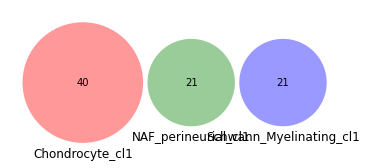

In [29]:
cts = ["Chondrocyte_cl1", "NAF_perineurial_cl1", "Schwann_Myelinating_cl1"]
venn3(subsets=[set(ct_cells[ct]) for ct in cts], set_labels=cts)

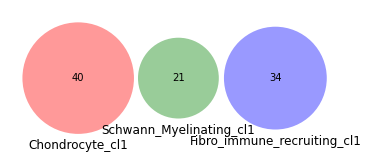

In [30]:
cts = ["Chondrocyte_cl1", "Schwann_Myelinating_cl1", "Fibro_immune_recruiting_cl1"]
venn3(subsets=[set(ct_cells[ct]) for ct in cts], set_labels=cts)

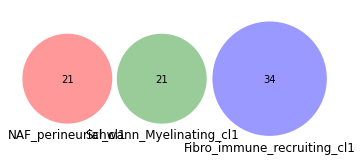

In [31]:
cts = ["NAF_perineurial_cl1", "Schwann_Myelinating_cl1", "Fibro_immune_recruiting_cl1"]
venn3(subsets=[set(ct_cells[ct]) for ct in cts], set_labels=cts)

Store cts by n_cells, and assign all cells in cl_fibs_sm to its cluster:

In [32]:
cts_ordered = ct_ncells.sort_values(ascending=False).index.tolist()
cl_fibs_sm.obs["spatial_clusters"] = "other"
for ct in cts_ordered:
    print(ct)
    cl_fibs_sm.obs.loc[ct_cells[ct], "spatial_clusters"] = ct

Chondrocyte_cl1
Fibro_immune_recruiting_cl1
NAF_perineurial_cl1
Schwann_Myelinating_cl1


/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


for nicer visual appearance, map names to clean names and colors and map non-spatial clusters on the bottom. 

In [33]:
spatial_cluster_cleaner = {
    #     "Fibro_peribronchial_cl1": "Peribronchial fibroblasts",
    #     "Fibro_ASPN_cl1": "Myofibroblasts",
    "NAF_perineurial_cl1": "Perineurial nerve-associated fibroblasts",
    # "NAF_1_cl1": "Endoneurial nerve-associated fibroblasts",
    "Fibro_immune_recruiting_cl1": "Immune-recruiting fibroblasts",
    "Chondrocyte_cl1": "Chondrocytes",
    "Schwann_Myelinating_cl1": "Schwann myelinating",
    # "Schwann_nonmyelinating_cl1": "Schwann non-myelinating",
    "other": "Other",
}
spatial_cluster_colors = {
    #     "Peribronchial fibroblasts": "tab:blue",
    "Other": "lightgrey",
    #     "Myofibroblasts": "tab:cyan",
    "Perineurial nerve-associated fibroblasts": "tab:red",
    "Endoneurial nerve-associated fibroblasts": "tab:orange",
    "Schwann myelinating": "tab:blue",
    "Schwann non-myelinating": "tab:green",
    "Immune-recruiting fibroblasts": "tab:pink",
    "Chondrocytes": "tab:orange",
}
cl_fibs_sm.obs["Spatial clusters"] = cl_fibs_sm.obs.spatial_clusters.map(
    spatial_cluster_cleaner
)
non_spatial_cells = cl_fibs_sm.obs.index[
    cl_fibs_sm.obs.spatial_clusters == "other"  # LISA CHECK. THIS
].tolist()
spatial_cells = cl_fibs_sm.obs.index[
    cl_fibs_sm.obs.spatial_clusters != "other"
].tolist()
cl_fibs_sm = cl_fibs_sm[non_spatial_cells + spatial_cells, :].copy()

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/ipykernel_launcher.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


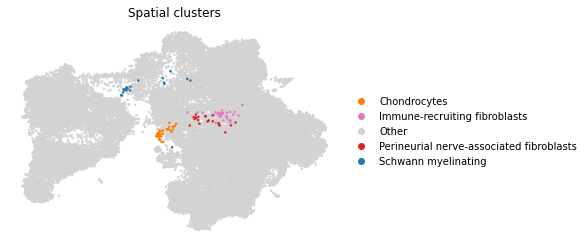

In [34]:
FIGURES["5e_meyer_spatial_clusters"] = sc.pl.umap(
    cl_fibs_sm,
    color="Spatial clusters",
    s=25,
    palette=spatial_cluster_colors,
    frameon=False,
    return_fig=True,
)

### Plot marker expression in spatial clusters:

reorder categories in spatial clusters, so that "Other" comes last:

In [35]:
cl_fibs_sm.obs["Spatial clusters"] = cl_fibs_sm.obs[
    "Spatial clusters"
].cat.reorder_categories(
    [cat for cat in cl_fibs_sm.obs["Spatial clusters"].unique() if cat != "Other"]
    + ["Other"]
)

In [36]:
meyer_markers = {
    "Immune-recruiting fibroblasts": ["CCL19", "CXCL12"],
    #     "Myofibroblasts": ["ASPN", "TAGLN", "CCDC68"],
    "Endoneurial nerve-associated fibroblasts": ["ANGPTL7", "THBS4", "USP54"],
    "Perineurial nerve-associated fibroblasts": [
        "SLC22A3",
        "STXBP6",
        "SLC2A1",
    ],
    #     "Peribronchial fibroblasts": ["COL15A1", "COL13A1", "ENTPD1"],
    #     "Fibro_perichondrial": ["COL12A1"],  # "only detected in sn data"
    #     "Schwann": ["PLP1", "MPZ", "S100B"],
    "Schwann myelinating": [
        "PRX",
        "MBP",
        "GLDN",
    ],
    "Schwann non-myelinating": [
        "SCN7A",
        "L1CAM",
        "NCAM1",
    ],
    "Chondrocytes": ["ACAN", "CHAD", "COL9A3"],  # "HAPLN1", "CYTL1"],
}

Chondrocytes
Immune-recruiting fibroblasts
Perineurial nerve-associated fibroblasts
Schwann myelinating


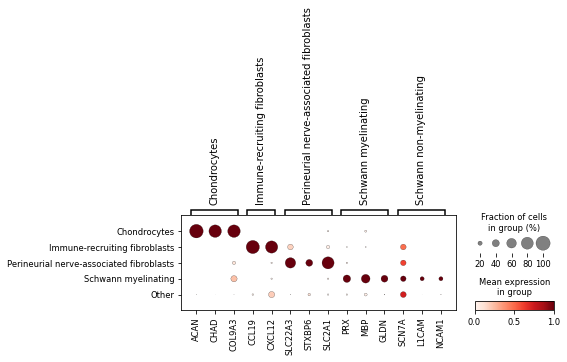

In [37]:
meyer_markers_list = list()
meyer_markers_ct_positions = list()
meyer_markers_labels = list()
pos_count = -1
ct_cluster_order = sorted(
    [cl for cl in cl_fibs_sm.obs["Spatial clusters"].cat.categories if cl != "Other"]
)
cl_fibs_sm.obs["Spatial clusters"] = cl_fibs_sm.obs[
    "Spatial clusters"
].cat.reorder_categories(ct_cluster_order + ["Other"])
for ct_cluster in ct_cluster_order:
    print(ct_cluster)

    markers = meyer_markers[ct_cluster]
    meyer_markers_labels.append(ct_cluster)
    meyer_markers_list += markers
    meyer_markers_ct_positions.append([pos_count + 1, pos_count + len(markers)])
    pos_count += len(markers)
    if ct_cluster.startswith("Schwann"):
        # also add the other Schwann markers:
        for marker_group, markers in meyer_markers.items():
            if marker_group.startswith("Schwann") and marker_group != ct_cluster:
                meyer_markers_labels.append(marker_group)
                meyer_markers_list += markers
                meyer_markers_ct_positions.append(
                    [pos_count + 1, pos_count + len(markers)]
                )
                pos_count += len(markers)
sc.pl.dotplot(
    cl_fibs_sm,
    groupby="Spatial clusters",
    var_names=meyer_markers_list,
    var_group_labels=meyer_markers_labels,
    var_group_positions=meyer_markers_ct_positions,
    standard_scale="var",
    dendrogram=False,
)

print cluster sizes:

In [38]:
for cl in cl_fibs_sm.obs["Spatial clusters"].unique():
    print(f"{cl}: n={(cl_fibs_sm.obs['Spatial clusters'] == cl).sum()}")

Other: n=39258
Schwann myelinating: n=21
Perineurial nerve-associated fibroblasts: n=21
Immune-recruiting fibroblasts: n=34
Chondrocytes: n=40


generate an obs column specifying for each spatial cluster if it is from reference (HLCA) or query (Meyer)

In [39]:
study_to_refvsq = {study: "HLCA" for study in cl_fibs_sm.obs.study.unique()}
study_to_refvsq["Meyer_2021"] = "query"
cl_fibs_sm.obs["spatial_clusters_refvsq"] = pd.Categorical(
    [
        f"{cl} ({study_to_refvsq[st]})"
        for cl, st in zip(cl_fibs_sm.obs["Spatial clusters"], cl_fibs_sm.obs.study)
    ]
)
# move other groups to end of categorical order:
ct_order_ref_vs_q = [
    "Chondrocytes (query)",
    "Immune-recruiting fibroblasts (HLCA)",
    "Immune-recruiting fibroblasts (query)",
    # "Endoneurial nerve-associated fibroblasts (HLCA)",
    # "Endoneurial nerve-associated fibroblasts (query)",
    "Perineurial nerve-associated fibroblasts (HLCA)",
    "Perineurial nerve-associated fibroblasts (query)",
    #     "Chondrocytes (HLCA)",  # not detected
    #     "Myofibroblasts (HLCA)",
    #     "Myofibroblasts (query)",
    #     "Peribronchial fibroblasts (HLCA)",
    #     "Peribronchial fibroblasts (query)",
    "Schwann myelinating (HLCA)",
    "Schwann myelinating (query)",
    # "Schwann non-myelinating (HLCA)",
    # "Schwann non-myelinating (query)",
    "Other (HLCA)",
    "Other (query)",
]
cl_fibs_sm.obs["spatial_clusters_refvsq"] = cl_fibs_sm.obs[
    "spatial_clusters_refvsq"
].cat.reorder_categories(ct_order_ref_vs_q)

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [40]:
sc.set_figure_params(fontsize=16)

In [41]:
FIGURES["ED_meyer_spatial_cluster_marker_expression_refvsq"] = sc.pl.dotplot(
    cl_fibs_sm,
    groupby="spatial_clusters_refvsq",
    var_names=meyer_markers_list,
    var_group_labels=meyer_markers_labels,
    var_group_positions=meyer_markers_ct_positions,
    standard_scale="var",
    return_fig=True,
    show=True,
    colorbar_title="Mean normalized\nexpr. in group",
    size_title="Positive cells\nin group (%)",
)

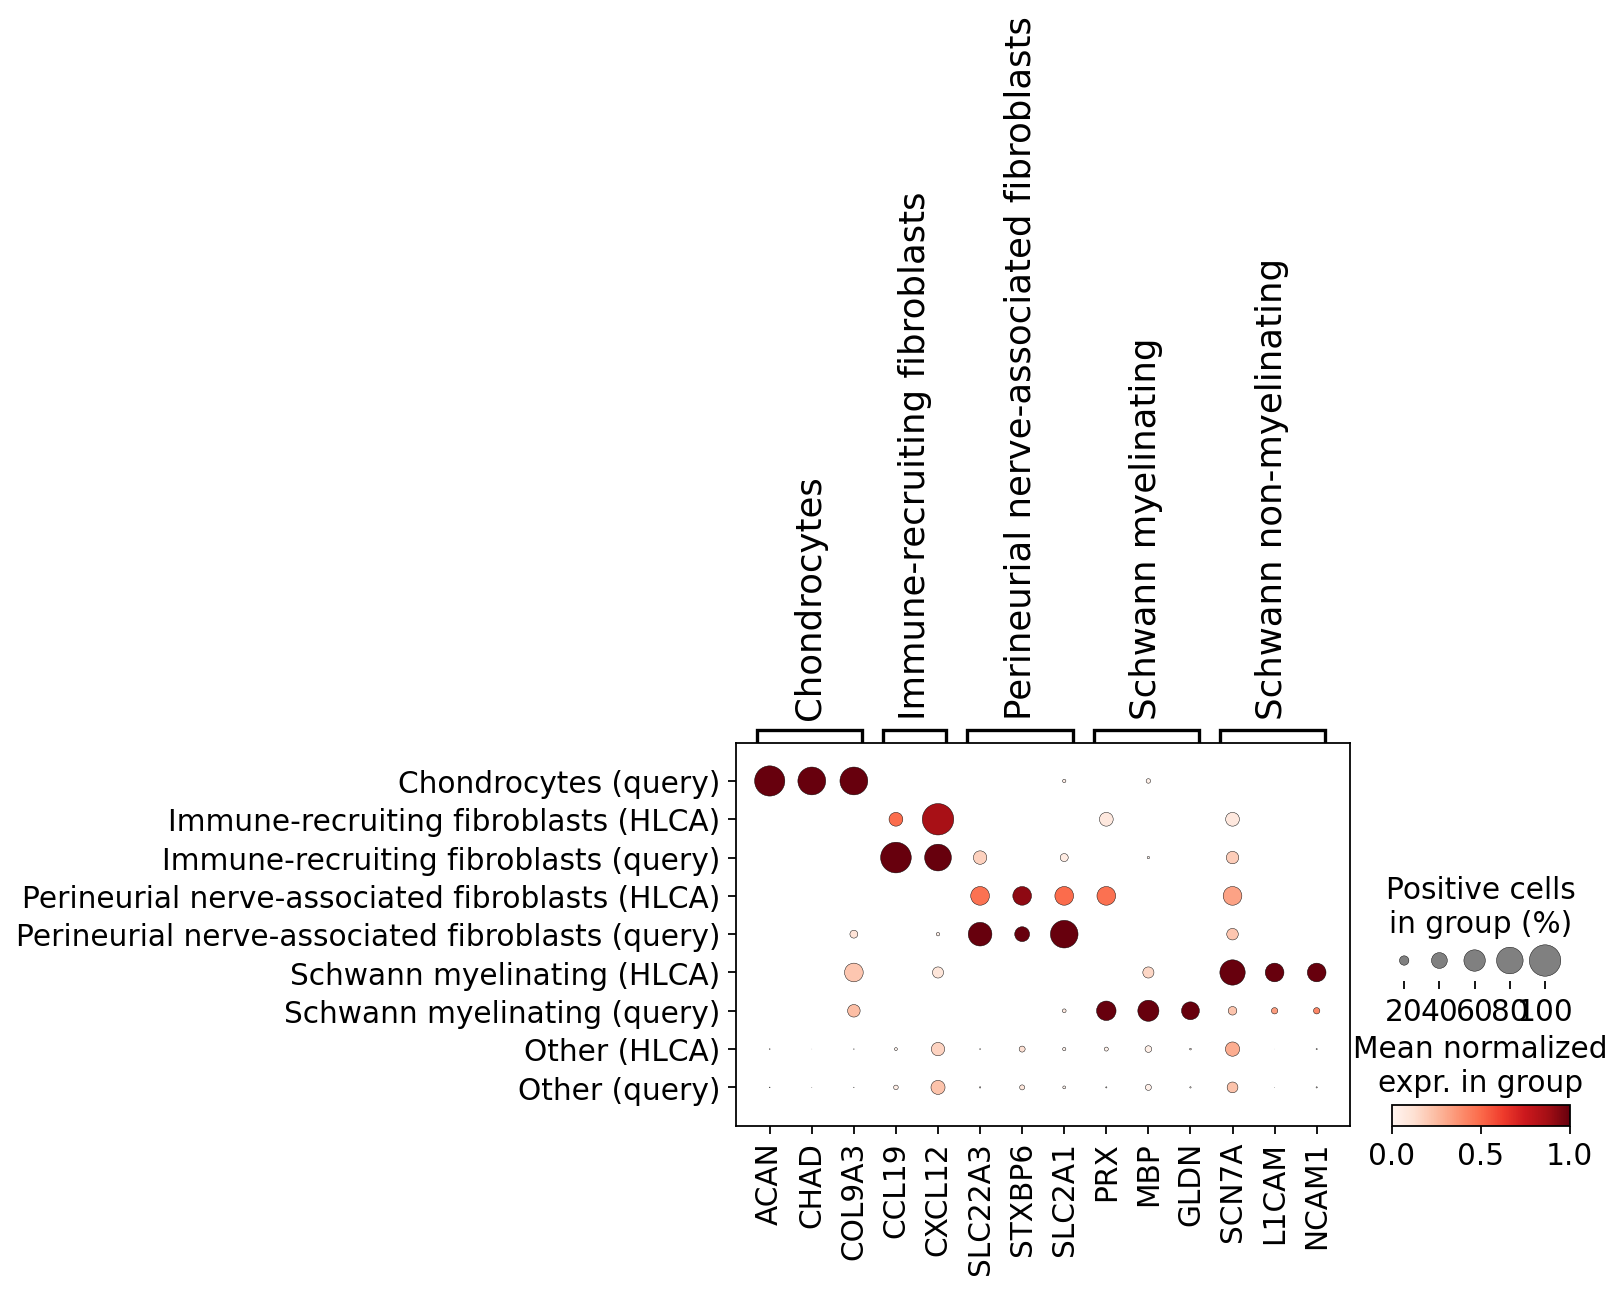

In [42]:
FIGURES["ED_meyer_spatial_cluster_marker_expression_refvsq"].show()

print cell numbers:

In [70]:
cl_fibs_sm.obs.spatial_clusters_refvsq.value_counts()

Other (HLCA)                                        24937
Other (query)                                       14321
Chondrocytes (query)                                   40
Immune-recruiting fibroblasts (query)                  31
Perineurial nerve-associated fibroblasts (query)       19
Schwann myelinating (query)                            17
Schwann myelinating (HLCA)                              4
Immune-recruiting fibroblasts (HLCA)                    3
Perineurial nerve-associated fibroblasts (HLCA)         2
Name: spatial_clusters_refvsq, dtype: int64

Show spatial cluster stats:

In [71]:
spatial_cluster_cell_counts_ref_vs_q = cl_fibs_sm.obs[
    "spatial_clusters_refvsq"
].value_counts()

In [72]:
spatial_ct_prec_rec["n_cells_in_Meyer_2021"] = ct_counts_meyer.loc[
    spatial_ct_prec_rec.index
]
spatial_ct_prec_rec["n_cells_in_Meyer_2021_perc_of_all"] = (
    spatial_ct_prec_rec["n_cells_in_Meyer_2021"] / adata.n_obs
) * 100
# reorder columns to correspond with paper table
spatial_ct_pre_rec = spatial_ct_prec_rec.loc[
    :,
    [
        "n_cells_in_Meyer_2021",
        "n_cells_in_Meyer_2021_perc_of_all",
        "mean_precision",
        "total_recall",
        "cl_res",
        "clusters",
    ],
]

In [73]:
spatial_ct_pre_rec

,n_cells_in_Meyer_2021,n_cells_in_Meyer_2021_perc_of_all,mean_precision,total_recall,cl_res,clusters
Fibro_immune_recruiting,59,0.00826,74.19,38.98,80,[561]
Chondrocyte,42,0.00588,90.0,85.71,80,[401]
NAF_endoneurial,35,0.00490,NaN,NaN,NaN,NaN
NAF_perineurial,31,0.00434,84.21,51.61,100,[973]
Schwann_Myelinating,7,0.00098,41.18,100.0,20,[232]
Schwann_nonmyelinating,29,0.00406,NaN,NaN,NaN,NaN


### Plot cluster composition:

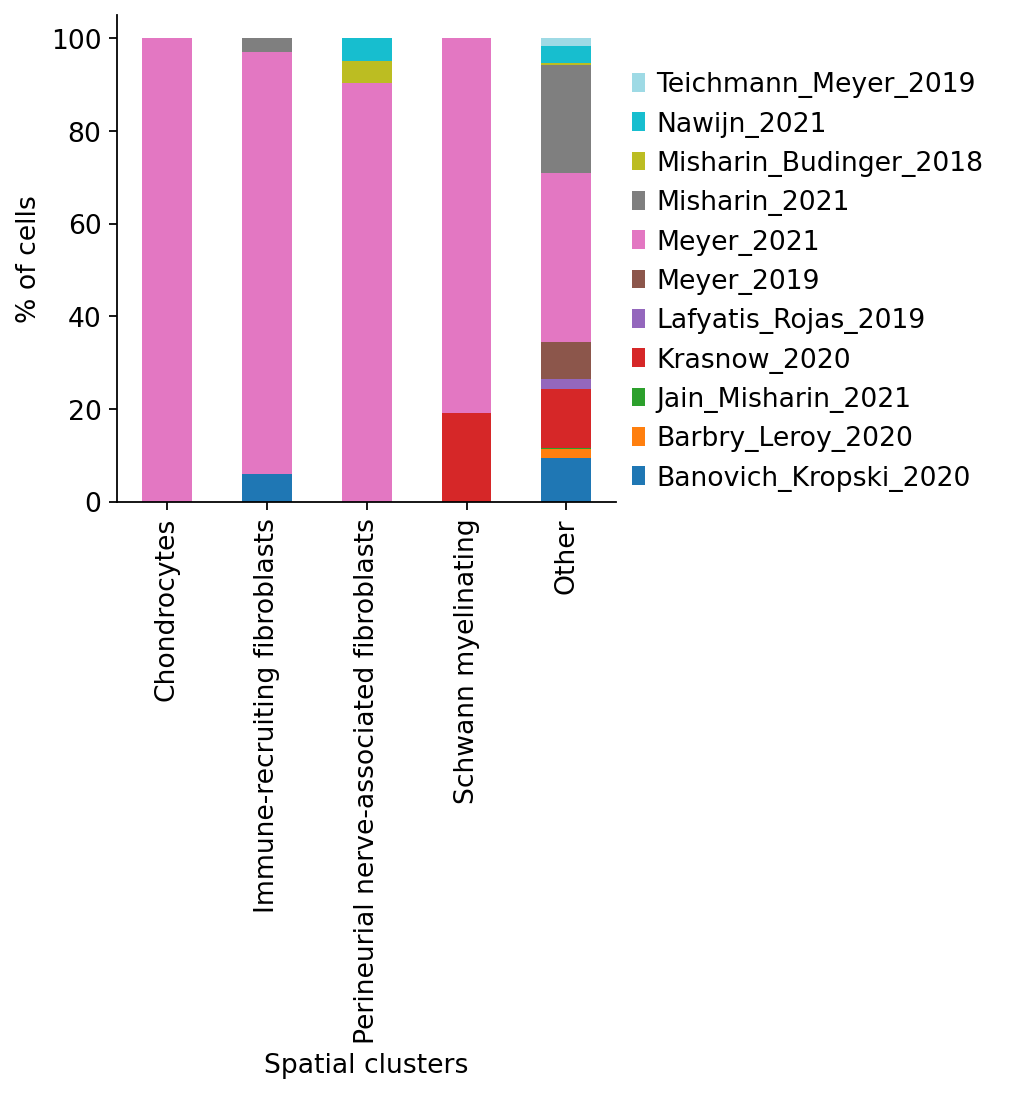

In [74]:
fz = 12
with plt.rc_context(
    {
        "figure.figsize": (4, 4),
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    study_per_ct_cluster = pd.crosstab(
        cl_fibs_sm.obs["Spatial clusters"], cl_fibs_sm.obs.study
    )
    study_per_ct_cluster_norm = (
        study_per_ct_cluster.divide(study_per_ct_cluster.sum(axis=1), axis="rows") * 100
    )
    fig, ax = plt.subplots()
    study_per_ct_cluster_norm.plot(kind="bar", stacked=True, cmap="tab20", ax=ax)
    # legend reverse order:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc=(1.01, 0.0), fontsize=fz, frameon=False)
    plt.ylabel("% of cells")
    plt.grid(False)
    plt.show()
    FIGURES["ED_meyer_spatial_cluster_study_composition"] = fig

anatomical locations of HLCA_cells:

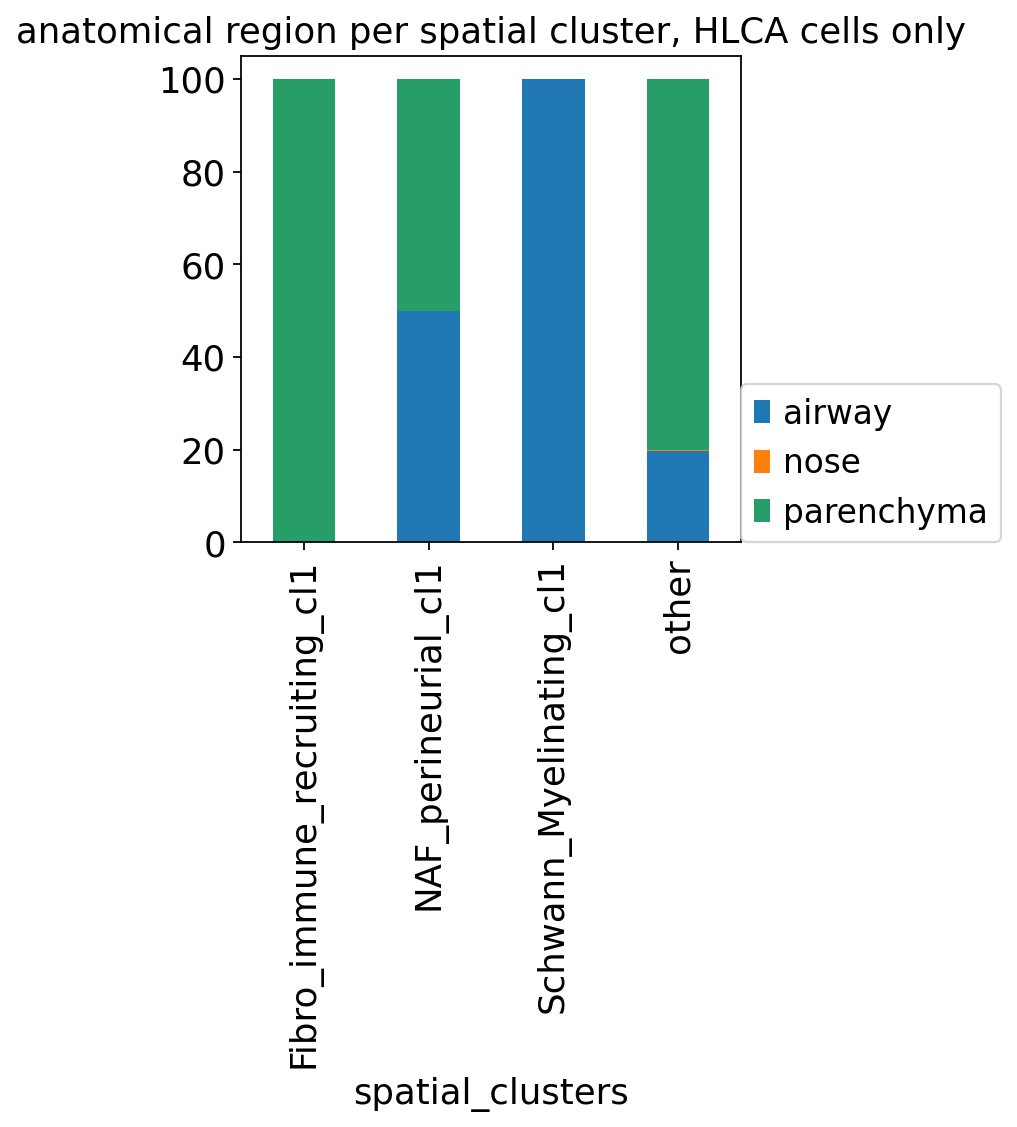

In [75]:
spatial_cl_an_region = pd.crosstab(
    cl_fibs_sm.obs.loc[cl_fibs_sm.obs.study != "Meyer_2021", "spatial_clusters"],
    cl_fibs_sm.obs.loc[
        cl_fibs_sm.obs.study != "Meyer_2021", "anatomical_region_level_1"
    ],
)
spatial_cl_an_region_norm = (
    spatial_cl_an_region.divide(spatial_cl_an_region.sum(axis=1), axis="rows") * 100
)
spatial_cl_an_region_norm.plot(kind="bar", stacked=True)
plt.legend(loc=(1, 0))
plt.title("anatomical region per spatial cluster, HLCA cells only")
plt.grid(False)
plt.show()

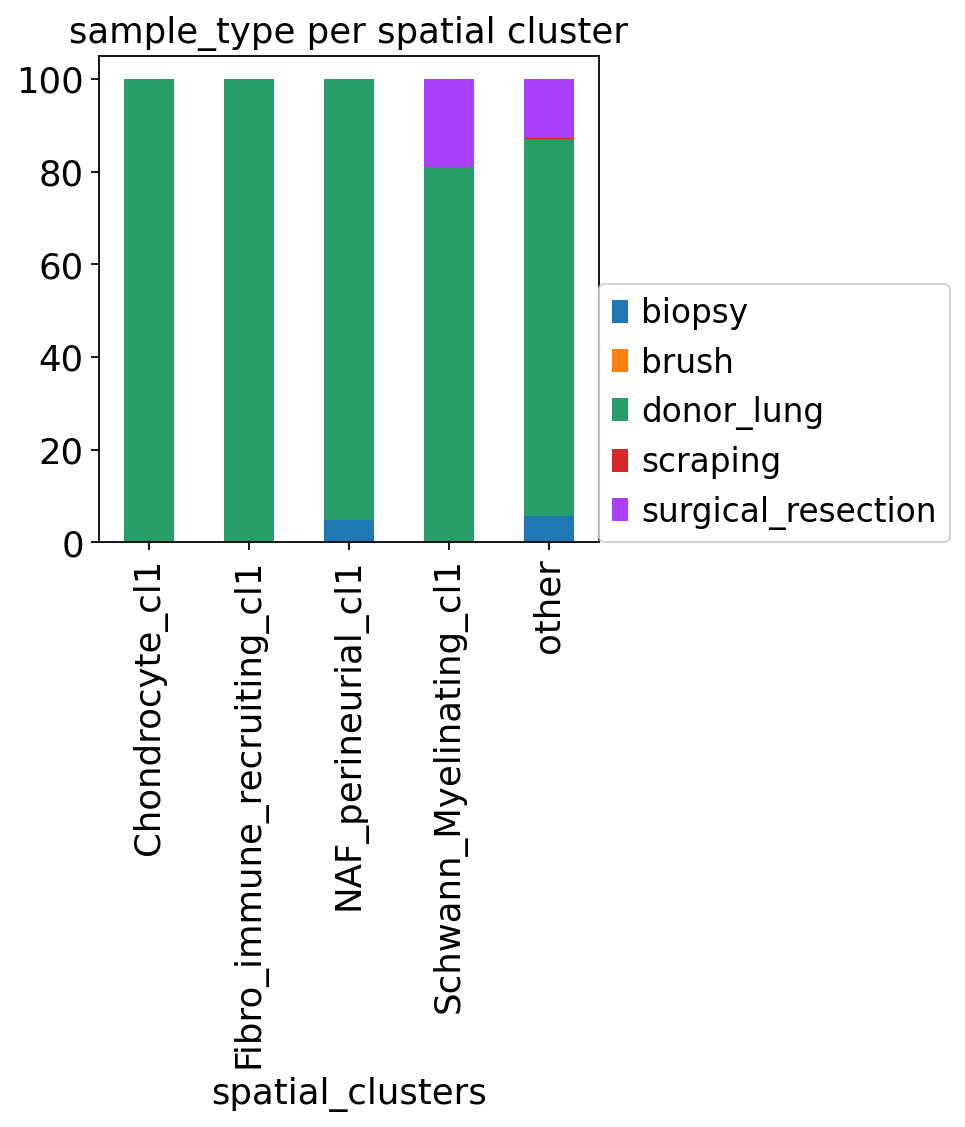

In [76]:
spatial_cl_an_region = pd.crosstab(
    cl_fibs_sm.obs.spatial_clusters, cl_fibs_sm.obs.sample_type
)
spatial_cl_an_region_norm = (
    spatial_cl_an_region.divide(spatial_cl_an_region.sum(axis=1), axis="rows") * 100
)
spatial_cl_an_region_norm.plot(kind="bar", stacked=True)
plt.legend(loc=(1, 0))
plt.title("sample_type per spatial cluster")
plt.grid(False)
plt.show()

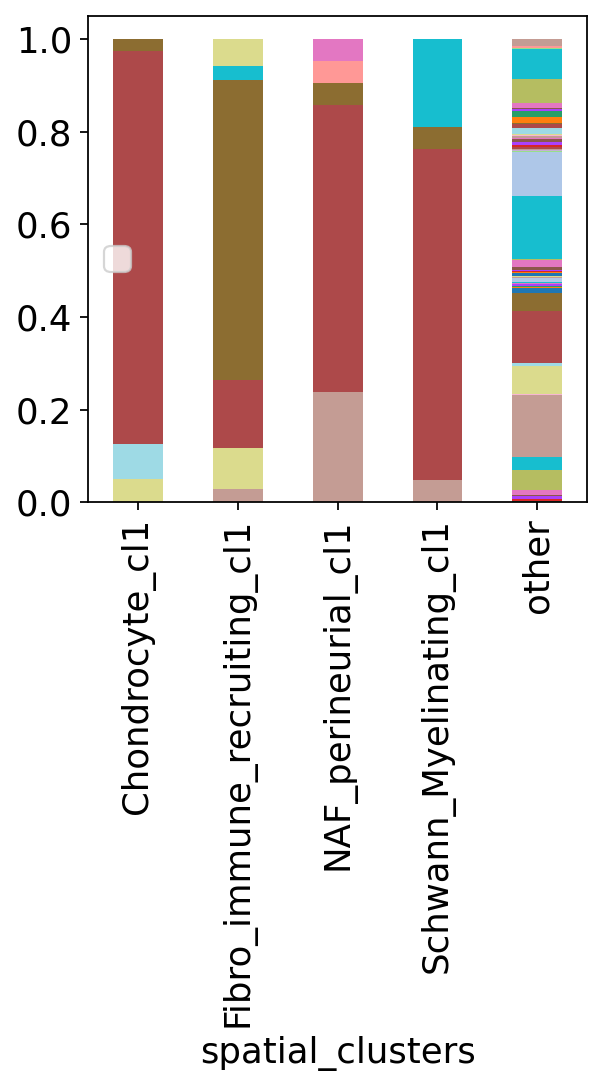

In [77]:
subject_per_spatial_cl = pd.crosstab(
    cl_fibs_sm.obs.spatial_clusters, cl_fibs_sm.obs.subject_ID
)
subject_per_spatial_cl = subject_per_spatial_cl.divide(
    subject_per_spatial_cl.sum(axis=1), axis="rows"
)
subject_per_spatial_cl.plot(kind="bar", stacked=True)
plt.legend([])
plt.grid(False)
plt.show()

CCL cluster mostly from one subject:

In [78]:
subject_per_spatial_cl.loc["Fibro_immune_recruiting_cl1", :].sort_values(
    ascending=False
).head(4)

subject_ID
A44       0.647059
A43       0.147059
A37       0.088235
VUHD92    0.058824
Name: Fibro_immune_recruiting_cl1, dtype: float64

original hlca cluster makeup:

In [79]:
adata.obs["spatial_clusters"] = "Other"
adata.obs.loc[cl_fibs_sm.obs.index, "Spatial clusters"] = cl_fibs_sm.obs[
    "Spatial clusters"
]

In [80]:
# fz = 12
# with plt.rc_context(
#     {
#         "figure.figsize": (5, 3),
#         "xtick.labelsize": fz,
#         "ytick.labelsize": fz,
#         "axes.labelsize": fz,
#         "font.size": fz,
#         "axes.spines.right": False,
#         "axes.spines.top": False,
#     }
# ):
#     fig, ax = plt.subplots()
#     hlca_cl_per_spatial_cl = pd.crosstab(
#         adata.obs.leiden_3, adata.obs["Spatial clusters"]
#     )
#     hlca_cl_per_spatial_cl = hlca_cl_per_spatial_cl.divide(
#         hlca_cl_per_spatial_cl.sum(axis=1), axis="rows"
#     )
#     # order columns as the rest of the figures and convert to percentages:
#     hlca_cl_per_spatial_cl = (
#         hlca_cl_per_spatial_cl.loc[
#             [cl for cl in hlca_cl_per_spatial_cl.index if cl != "nan"],
#             [ct for ct in ct_order if ct in hlca_cl_per_spatial_cl.columns],
#         ]
#         * 100
#     )
#     hlca_cl_per_spatial_cl.plot(
#         kind="bar",
#         stacked=True,
#         ax=ax,
#         color=hlca_cl_per_spatial_cl.columns.map(spatial_cluster_colors).tolist(),
#     )
#     plt.xlabel("HLCA cluster")
#     plt.ylabel("% of cells")
#     plt.legend(loc=(1.01, 0), frameon=False)
#     plt.grid(False)
#     plt.show()
#     FIGURES["4_meyer_spatial_clusters_per_HLCA_leiden_3_cluster"] = fig

Show cluster makeup (clusters from original HCA) for spatial clusters:

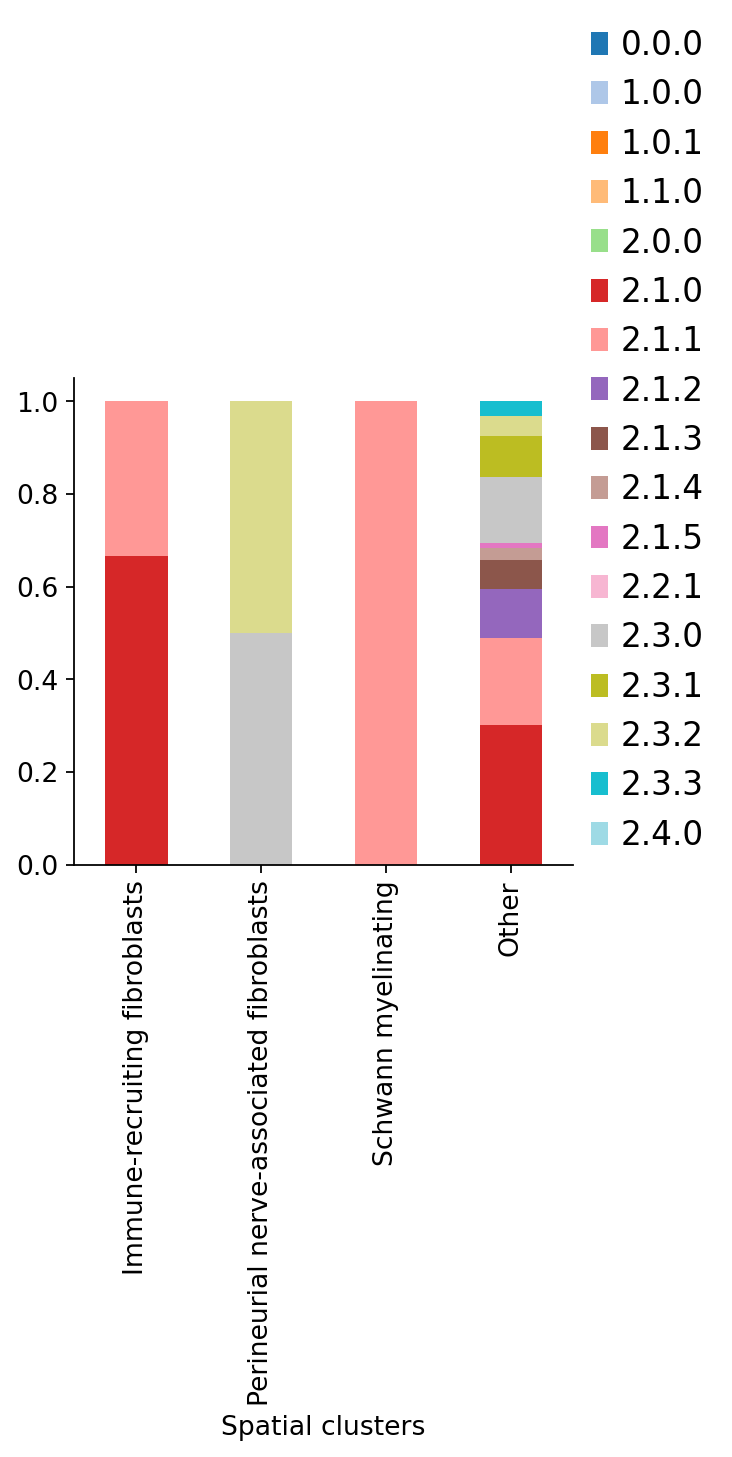

In [54]:
fz = 12
with plt.rc_context(
    {
        # "figure.figsize": (12, 3),
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    hlca_cl_per_spatial_cl = pd.crosstab(
        adata.obs["Spatial clusters"], adata.obs.leiden_3
    )
    hlca_cl_per_spatial_cl = hlca_cl_per_spatial_cl.divide(
        hlca_cl_per_spatial_cl.sum(axis=1), axis="rows"
    )
    # order columns as the rest of the figures:
    #     hlca_cl_per_spatial_cl = hlca_cl_per_spatial_cl.loc[
    #         :, [ct for ct in ct_order if ct in hlca_cl_per_spatial_cl.columns]
    #     ]
    hlca_cl_per_spatial_cl.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        cmap="tab20",
    )
    plt.legend(loc=(1.01, 0), frameon=False)
    plt.grid(False)
    plt.show()

show original annotations (level 4) per spatial cluster, from non-meyer data:

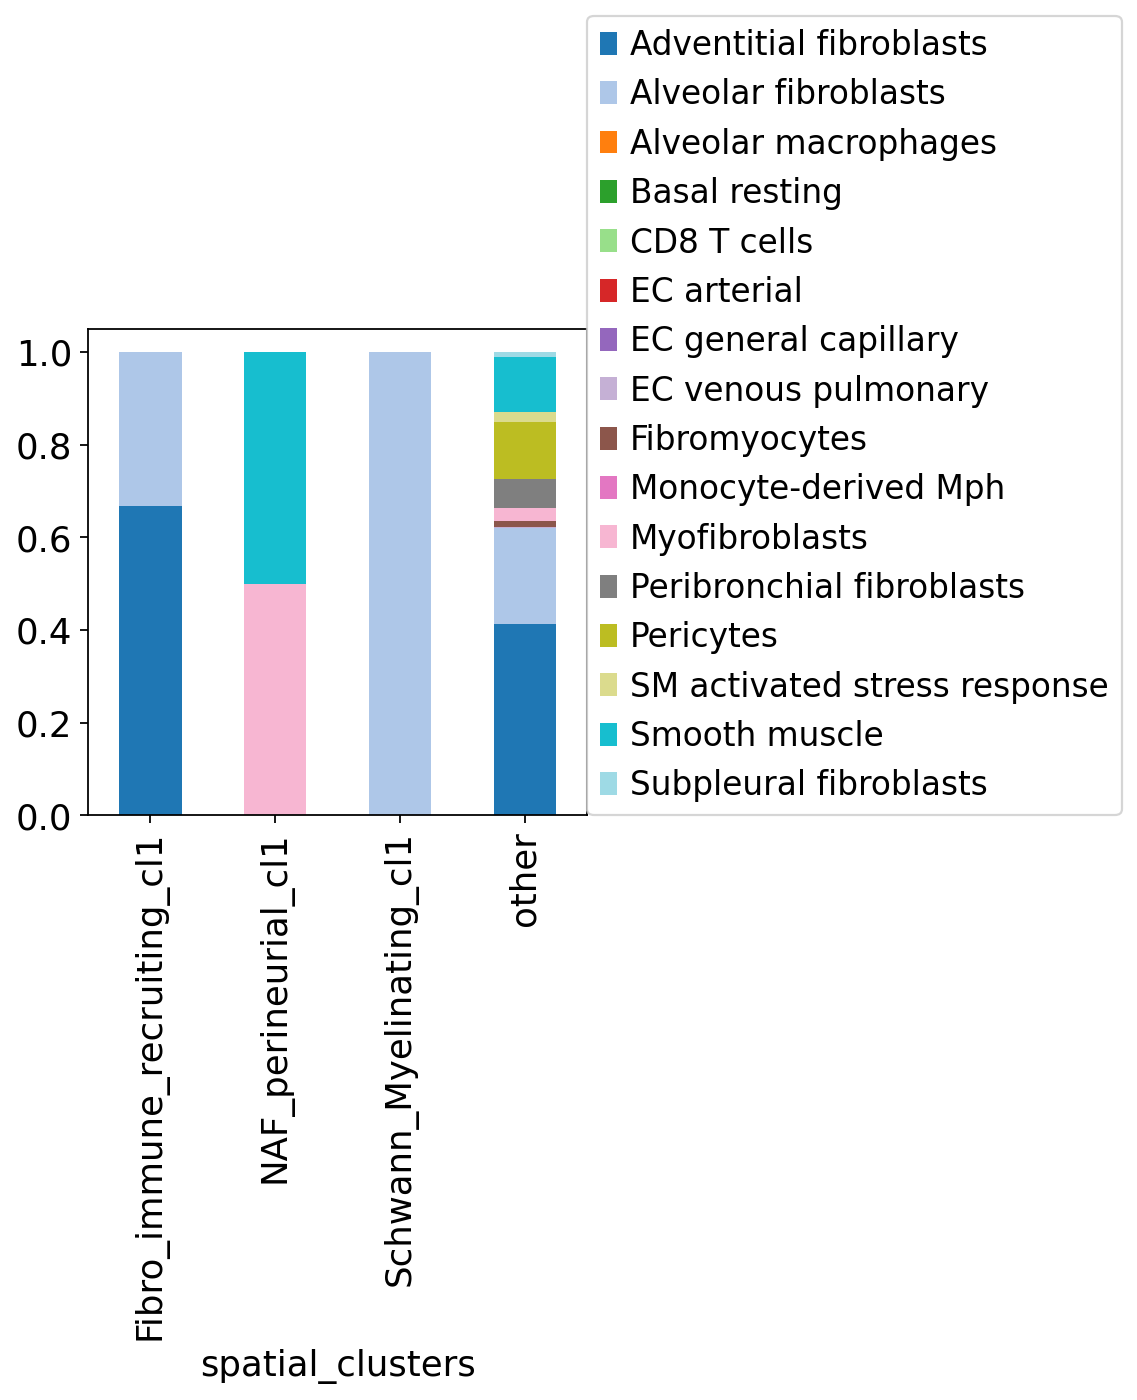

In [55]:
hlca_ann_per_spatial_cl_unnormalized = pd.crosstab(
    cl_fibs_sm.obs.loc[cl_fibs_sm.obs.study != "Meyer_2021", "spatial_clusters"],
    cl_fibs_sm.obs.loc[cl_fibs_sm.obs.study != "Meyer_2021", "manual_ann"],
)
hlca_ann_per_spatial_cl = hlca_ann_per_spatial_cl_unnormalized.divide(
    hlca_ann_per_spatial_cl_unnormalized.sum(axis=1), axis="rows"
)
# # filter out clusters that are >0.99 "other"
# hlca_ann_per_spatial_cl = hlca_ann_per_spatial_cl.loc[
#     hlca_ann_per_spatial_cl.other < 0.99, :
# ].copy()
# sort alphabetically
hlca_ann_per_spatial_cl = hlca_ann_per_spatial_cl.loc[
    sorted(hlca_ann_per_spatial_cl.index), :
].copy()
hlca_ann_per_spatial_cl.plot(kind="bar", stacked=True, cmap="tab20")
plt.grid(False)
plt.legend(loc=(1, 0))
plt.show()

In [56]:
hlca_ann_per_spatial_cl_unnormalized.sum(axis=1)

spatial_clusters
Fibro_immune_recruiting_cl1        3
NAF_perineurial_cl1                2
Schwann_Myelinating_cl1            4
other                          24937
dtype: int64

In [57]:
spatial_ct = "Fibro_immune_recruiting_cl1"  # "Fibro_adventitial_CCL_cl1"  # "NAF_2_cl1"
hlca_ann_per_spatial_cl.loc[spatial_ct, hlca_ann_per_spatial_cl.loc[spatial_ct, :] != 0]

manual_ann
Adventitial fibroblasts    0.666667
Alveolar fibroblasts       0.333333
Name: Fibro_immune_recruiting_cl1, dtype: float64

### calculate marker genes per annotation:

In [58]:
sc.tl.rank_genes_groups(
    cl_fibs_sm, groupby="original_celltype_ann_meyer", use_raw=False
)

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/sca

In [59]:
sc.tl.filter_rank_genes_groups(
    cl_fibs_sm, use_raw=False, min_in_group_fraction=0.25, max_out_group_fraction=0.1
)

In [60]:
ct_datadriven_markers = dict()
for ct in cts_ordered:
    ct = ct.split("_cl")[0]
    print(ct)
    deg_df = sc.get.rank_genes_groups_df(
        cl_fibs_sm, group=ct, key="rank_genes_groups_filtered"
    )
    ct_datadriven_markers[ct] = list(deg_df.names[~pd.isnull(deg_df.names)][:5].values)

Chondrocyte
Fibro_immune_recruiting
NAF_perineurial
Schwann_Myelinating


Chondrocyte
Fibro_immune_recruiting
NAF_perineurial
Schwann_Myelinating
other


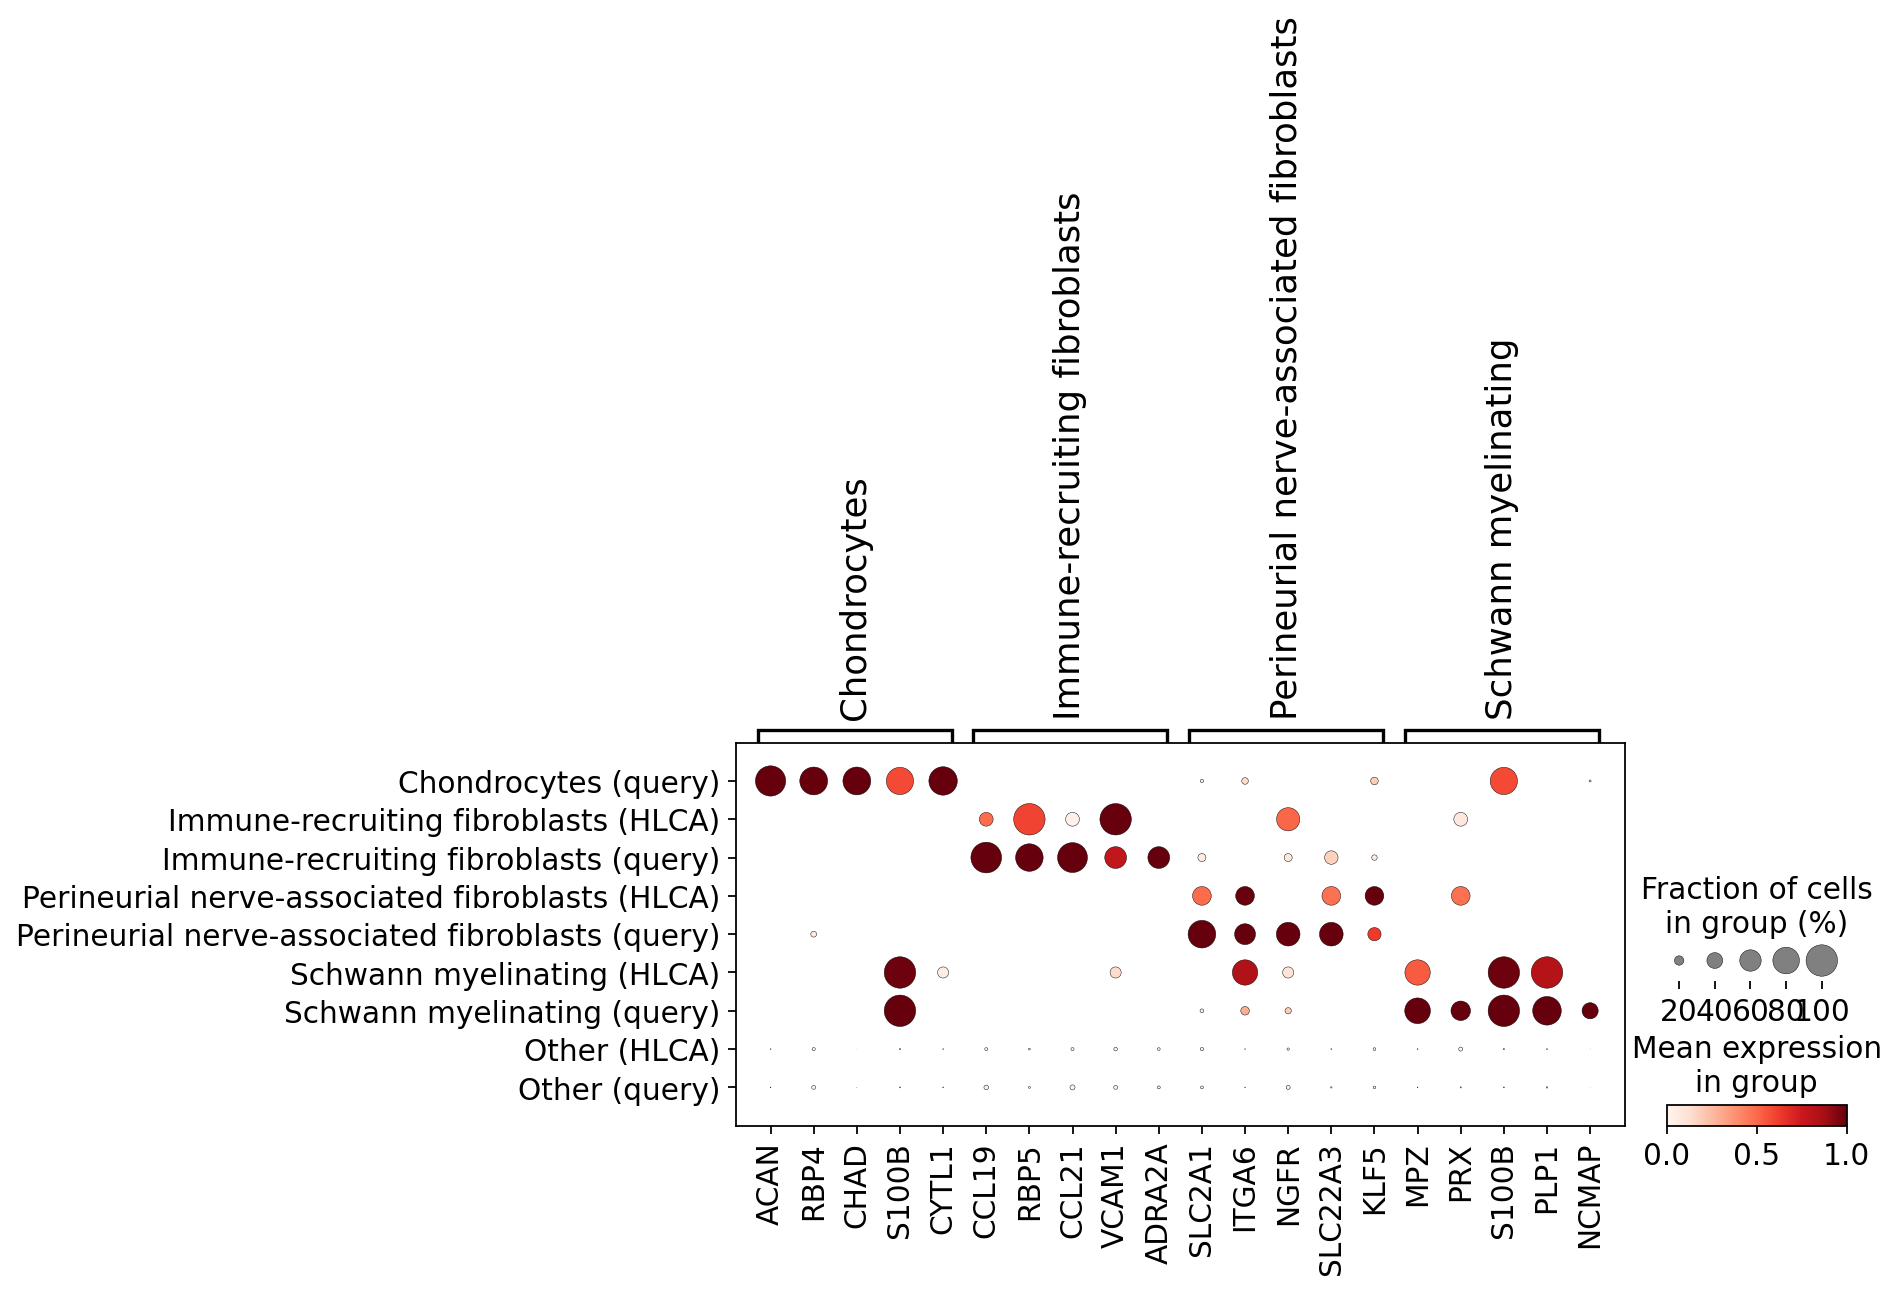

In [61]:
datadriven_markers_list = list()
datadriven_markers_ct_positions = list()
datadriven_markers_labels = list()
pos_count = -1
for ct_cluster in cl_fibs_sm.obs.spatial_clusters.cat.categories:
    ct_cluster_short = ct_cluster.split("_cl")[0]
    print(ct_cluster_short)
    ct = spatial_cluster_cleaner[ct_cluster]
    if ct_cluster_short != "other" and ct not in datadriven_markers_labels:
        markers = ct_datadriven_markers[ct_cluster_short]
        datadriven_markers_labels.append(ct)
        datadriven_markers_list += markers
        datadriven_markers_ct_positions.append(
            [pos_count + 1, pos_count + len(markers)]
        )
        pos_count += len(markers)
sc.pl.dotplot(
    cl_fibs_sm,
    groupby="spatial_clusters_refvsq",
    var_names=datadriven_markers_list,
    var_group_labels=datadriven_markers_labels,
    var_group_positions=datadriven_markers_ct_positions,
    standard_scale="var",
)

### Calculate marker gene expression per "spatial cluster"

In [62]:
sc.tl.rank_genes_groups(cl_fibs_sm, groupby="Spatial clusters", use_raw=False)

In [63]:
sc.tl.filter_rank_genes_groups(
    cl_fibs_sm, use_raw=False, min_in_group_fraction=0.25, max_out_group_fraction=0.1
)

In [64]:
ct_spatial_cluster_markers = dict()
for spatial_cl in cl_fibs_sm.obs["Spatial clusters"].unique():
    deg_df = sc.get.rank_genes_groups_df(
        cl_fibs_sm, group=spatial_cl, key="rank_genes_groups_filtered"
    )
    ct_spatial_cluster_markers[spatial_cl] = list(
        deg_df.names[~pd.isnull(deg_df.names)][:5].values
    )

In [65]:
cl_fibs_sm.obs.spatial_clusters_refvsq.value_counts()

Other (HLCA)                                        24937
Other (query)                                       14321
Chondrocytes (query)                                   40
Immune-recruiting fibroblasts (query)                  31
Perineurial nerve-associated fibroblasts (query)       19
Schwann myelinating (query)                            17
Schwann myelinating (HLCA)                              4
Immune-recruiting fibroblasts (HLCA)                    3
Perineurial nerve-associated fibroblasts (HLCA)         2
Name: spatial_clusters_refvsq, dtype: int64

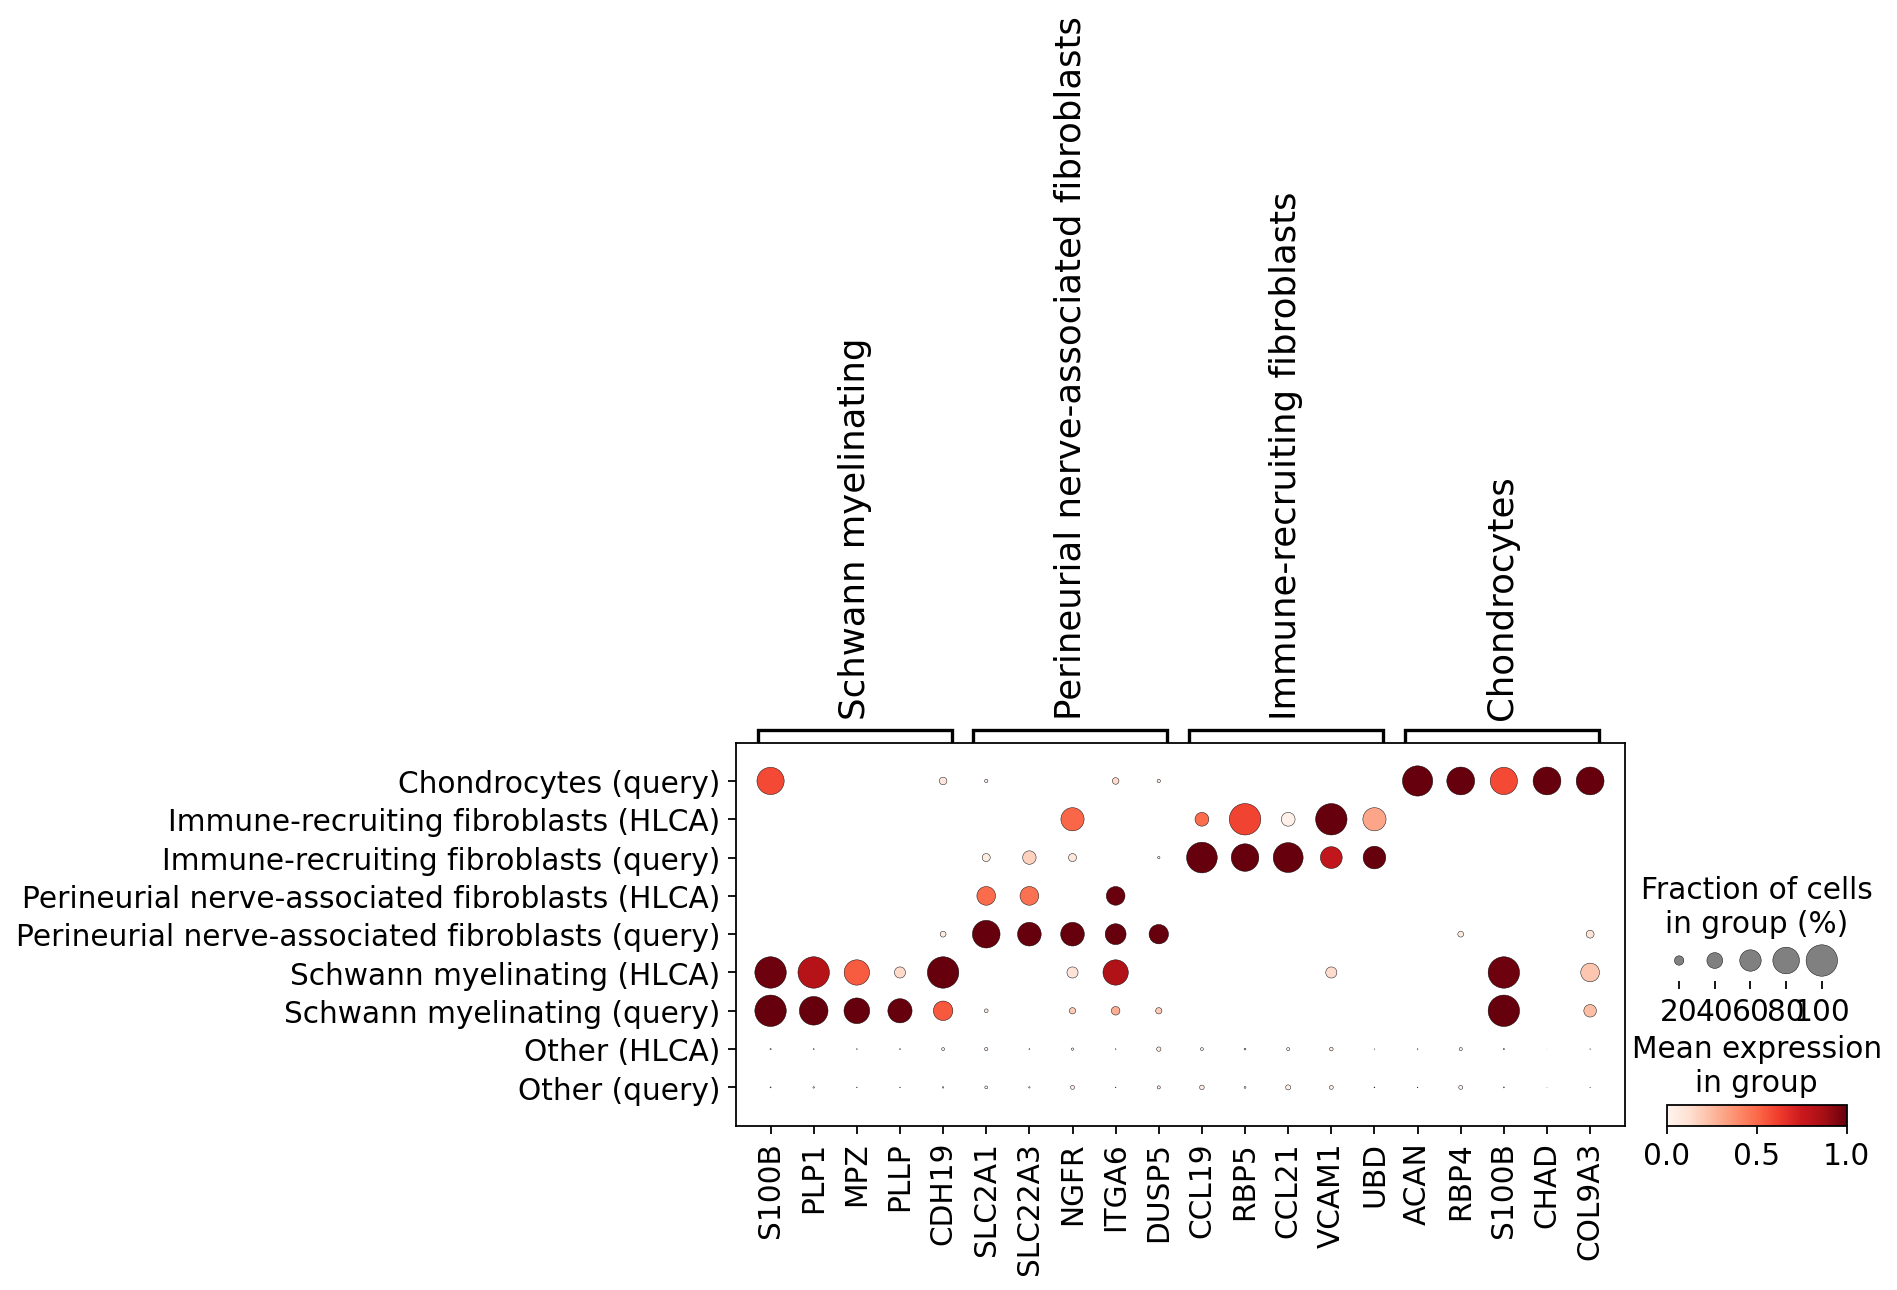

In [66]:
spatial_cluster_markers_list = list()
spatial_cluster_markers_ct_positions = list()
spatial_cluster_markers_labels = list()
pos_count = -1
for ct_cluster in cl_fibs_sm.obs["Spatial clusters"].unique():
    if ct_cluster != "Other" and ct_cluster not in spatial_cluster_markers_labels:
        markers = ct_spatial_cluster_markers[ct_cluster]
        spatial_cluster_markers_labels.append(ct_cluster)
        spatial_cluster_markers_list += markers
        spatial_cluster_markers_ct_positions.append(
            [pos_count + 1, pos_count + len(markers)]
        )
        pos_count += len(markers)
# FIGURES["4_meyer_spatial_cluster_markers_refvsq_dotplot"] =
sc.pl.dotplot(
    cl_fibs_sm,
    groupby="spatial_clusters_refvsq",
    var_names=spatial_cluster_markers_list,
    var_group_labels=spatial_cluster_markers_labels,
    var_group_positions=spatial_cluster_markers_ct_positions,
    standard_scale="var",
    # return_fig=True,
)

### store figures + recall/precision numbers:

In [81]:
spatial_cluster_cell_counts_ref_vs_q.to_csv(
    os.path.join(dir_figures, "ED_meyer_cell_counts_per_spatial_clusters.csv")
)

In [82]:
spatial_ct_prec_rec.to_csv(
    os.path.join(dir_figures, "ED_meyer_prec_recall_spatial_clusters.csv")
)

In [83]:
for figname, fig in FIGURES.items():
    print("Storing", figname)
    fig.savefig(
        os.path.join(dir_figures, f"{figname}.png"), bbox_inches="tight", dpi=140
    )
    plt.close()

Storing 5e_meyer_spatial_clusters
Storing ED_meyer_spatial_cluster_marker_expression_refvsq
Storing ED_meyer_spatial_cluster_study_composition


or store only a specific figure:

In [70]:
# figname = "4_meyer_spatial_cluster_marker_expression_refvsq"

In [71]:
# print("Storing", figname)
# FIGURES[figname].savefig(os.path.join(dir_figures, f"{figname}.png"), bbox_inches="tight", dpi=140)
# plt.close()